In [123]:
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusUCBDelegationMechanism,
)
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
import numpy as np
import matplotlib as mpl
import seaborn as sns

### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

In [124]:
batch_size = 128
# window_size = 50
window_size = 55
num_trials = 5
n_voters = 5

In [125]:
data = Data(
    data_set_name="mnist",
    # train_digit_groups=[range(5), range(5, 10)],
    # train_digit_groups=[[0, 1, 2], [3, 4, 5,], [6, 7, 8, 9]],
    train_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
    # test_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
    # test_digit_groups=[range(5), range(5, 10)],
    test_digit_groups=[range(10)],
    batch_size=batch_size,
)

NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)

proba_slope_del_mech = ProbaSlopeDelegationMechanism(
    batch_size=batch_size, window_size=window_size
)

restricted_max_guru_del_mech = RestrictedMaxGurusUCBDelegationMechanism(
    batch_size=batch_size,
    num_voters=n_voters,
    max_active_voters=2,
    window_size=window_size,
    t_between_delegation=3,
)

ensembles = [
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=NOOP_del_mech,
        name="full_ensemble",
        input_dim=28 * 28,
        output_dim=10,
    ),
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=proba_slope_del_mech,
        name="proba_slope_delegations",
        input_dim=28 * 28,
        output_dim=10,
    ),
    # Ensemble(
    #     training_epochs=1,
    #     n_voters=n_voters,
    #     delegation_mechanism=restricted_max_guru_del_mech,
    #     name="restricted_max_guru_delegations",
    #     input_dim=28 * 28,
    #     output_dim=10,
    # ),
]

exp = Experiment(n_trials=num_trials, ensembles=ensembles, data=data, seed=4090)
_ = exp.run()

100%|██████████| 5/5 [01:35<00:00, 19.04s/it]


In [126]:
proba_slope_avg_test_accs, proba_slope_std_test_accs = calculate_avg_std_test_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_test_accs, full_std_test_accs = calculate_avg_std_test_accs(
    exp, "full_ensemble", num_trials
)

(
    proba_slope_avg_test_accs_per_trial,
    proba_slope_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "proba_slope_delegations", num_trials)
(
    full_avg_test_accs_per_trial,
    full_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "full_ensemble", num_trials)

In [127]:
print(
    "Mean test accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_test_accs),
)
print("Mean test accs for full ensemble: ", np.mean(full_avg_test_accs))

# print(
#     "Mean test accs for restricted_max_guru delegation ensemble: ",
#     np.mean(restricted_max_guru_avg_test_accs),
# )

Mean test accs for proba_slope delegation ensemble:  0.30704113924050624
Mean test accs for full ensemble:  0.19254351265822786


In [138]:
# print std information
print(
    "Std test accs for proba_slope delegation ensemble: ",
    np.std(proba_slope_avg_test_accs_per_trial) * 100,
)
print("Std test accs for full ensemble: ", np.std(full_avg_test_accs_per_trial) * 100)

Std test accs for proba_slope delegation ensemble:  5.438821196265522
Std test accs for full ensemble:  0.14734636496985082


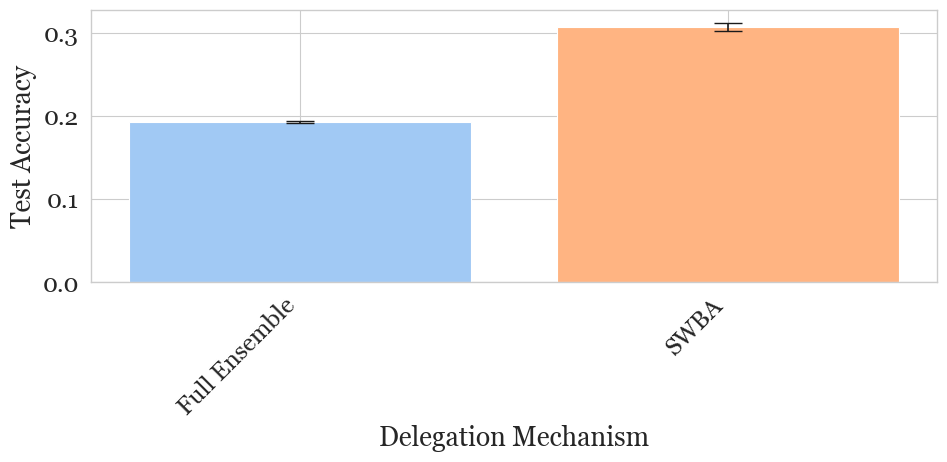

In [142]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1])
ax.set_xticklabels(["Full Ensemble", "SWBA"], rotation=45, ha="right")
# Data for bar plot
means = [
    np.mean(full_avg_test_accs_per_trial),
    np.mean(proba_slope_avg_test_accs_per_trial),
]
stds = [
    np.std(full_avg_test_accs_per_trial),
    np.std(proba_slope_std_test_accs_per_trial),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [130]:
proba_slope_avg_train_accs, proba_slope_std_train_accs = calculate_avg_std_train_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

# (
#     restricted_max_guru_avg_train_accs,
#     restricted_max_guru_std_train_accs,
# ) = calculate_avg_std_train_accs(exp, "restricted_max_guru_delegations", num_trials)

print(
    "Mean train accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

# print(
#     "Mean train accs for restricted_max_guru delegation ensemble: ",
#     np.mean(restricted_max_guru_avg_train_accs),
# )

Mean train accs for proba_slope delegation ensemble:  0.8403262704420191
Mean train accs for full ensemble:  0.8061711531458124


In [131]:
train_splits = exp.train_splits

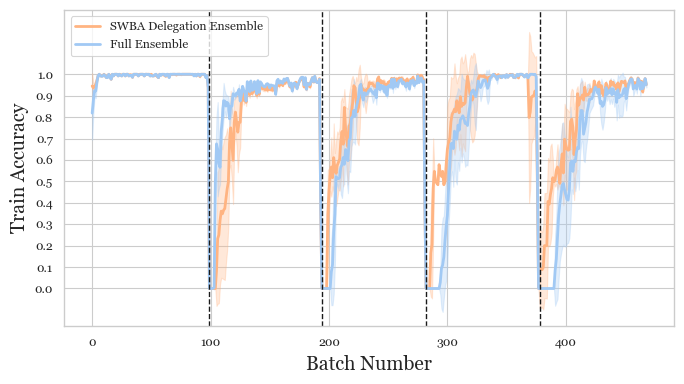

In [141]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(7, 4))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="SWBA Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
# ax.set_title("Train Accuracies for SWBA Delegation Ensemble and Full Ensemble")

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [133]:
ps_voters = exp.ensembles[1].voters
print(ensembles[1].name)
batch_accs = []
for v in ps_voters:
    batch_accs.append(v.batch_accuracies)

proba_slope_delegations


In [134]:
len_train = len(data.train_data_loader.dataset) / batch_size

In [135]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["proba_slope_delegations"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

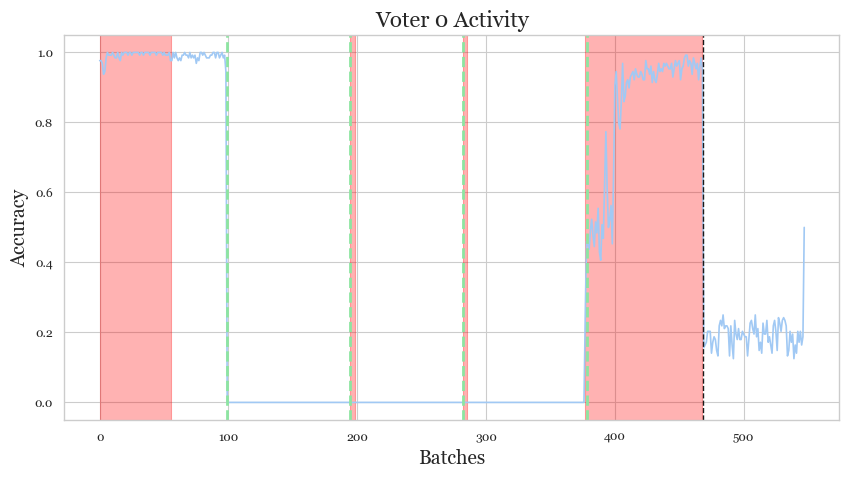

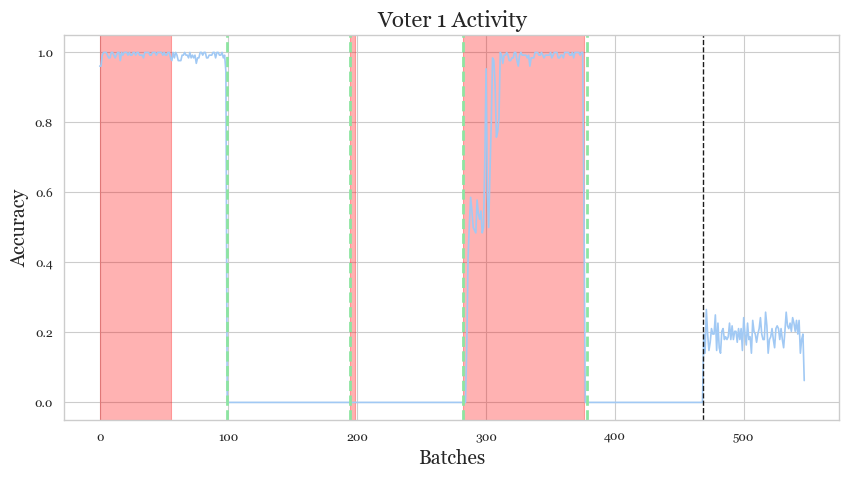

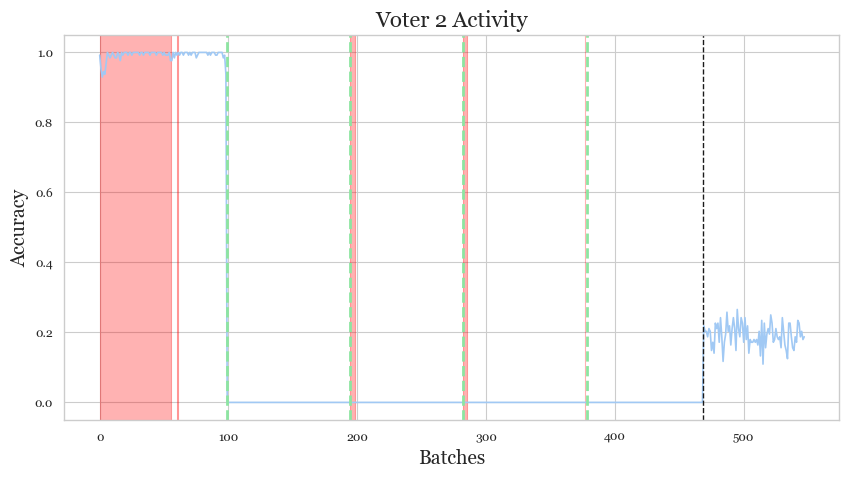

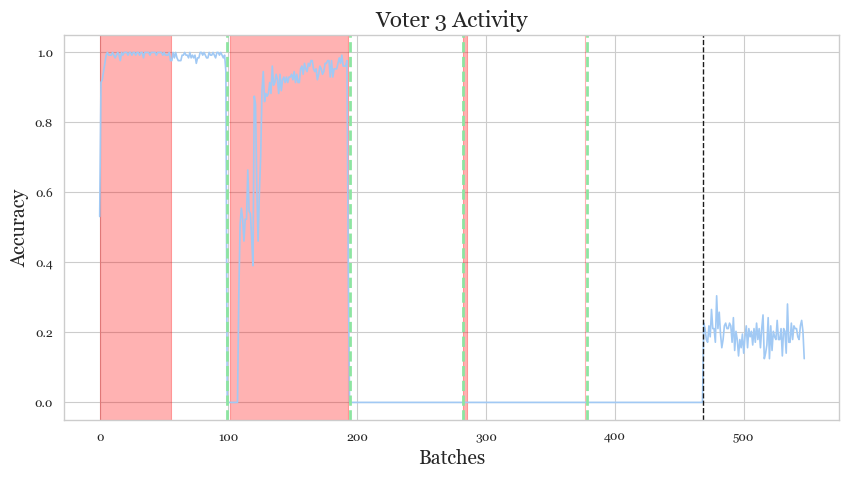

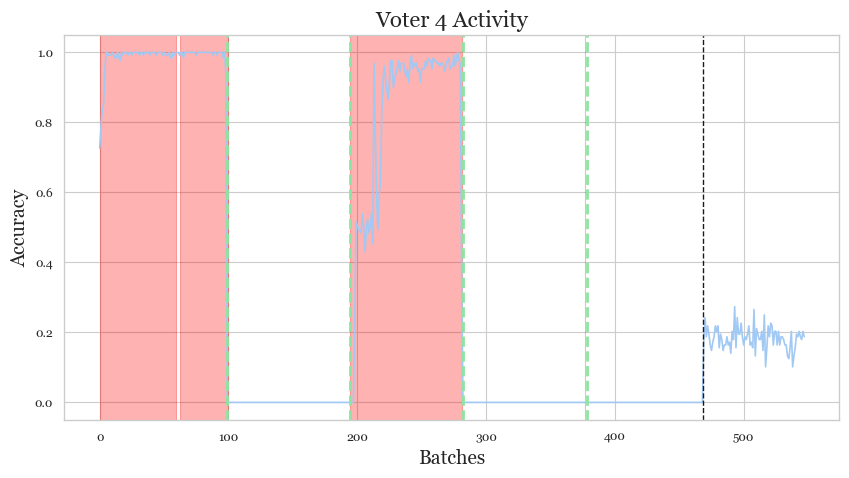

In [136]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter

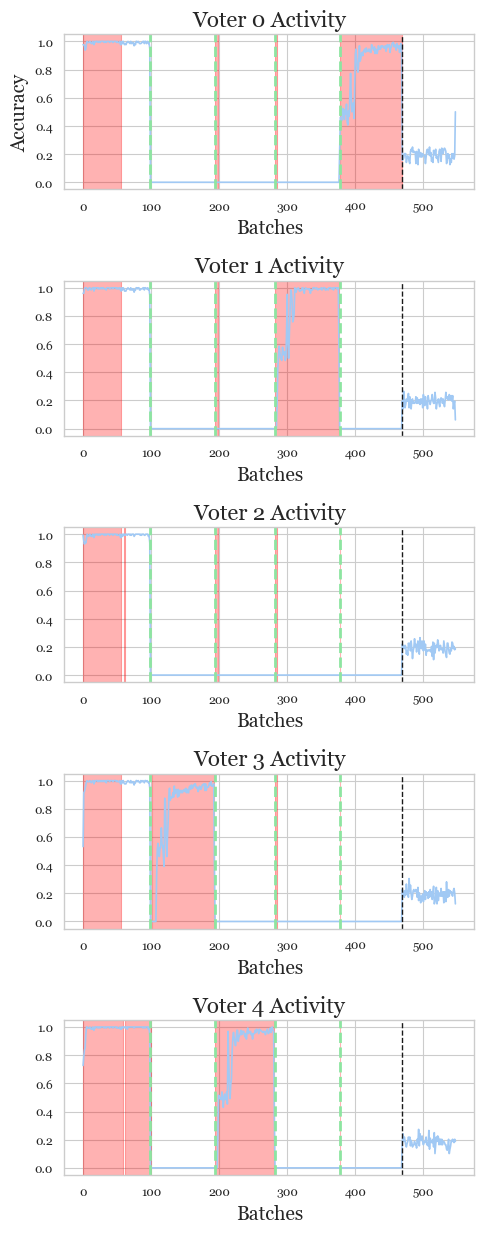

In [137]:
fig, axes = plt.subplots(
    n_voters, 1, figsize=(5, 2.5 * n_voters)
)  # Adjust the figure size as needed

for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    ax = axes[voter_id]  # Get the current axis

    ax.plot(batch_accs[voter_id])
    ax.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            ax.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        ax.axvline(x=split, color="g", linestyle="--", linewidth=2)

    ax.set_title(f"Voter {voter_id} Activity")
    ax.set_xlabel("Batches")
    if voter_id == 0:  # Only label the y-axis for the first plot
        ax.set_ylabel("Accuracy")

plt.tight_layout()
plt.show()  # Display all plots at once